<a href="https://colab.research.google.com/github/AravindhanV/LeafNet/blob/master/LeafNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LeafNet
###A Deep-Learning powered system used to Detect and Classifiy the disease of a plant.

####The system is made of three phases:
- Leaf  Detector
- Leaf Classifier
- Disease Classifier

##Getting Started

***
####Obtain Dataset

In [0]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 41.69 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


####Importing libraries

In [0]:
import numpy as np
import cv2
import imutils
from keras.preprocessing import image as kimage
from keras.applications import ResNet50
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Convolution2D,Dropout,MaxPooling2D,GlobalAveragePooling2D,Flatten,Dense
import os
import time

Using TensorFlow backend.


## Leaf Detector - YOLOv3

<!-- *The detector is trained on darknet architecture* -->

####Obtain the test image and create a directory to store image rotations

In [0]:
image = cv2.imread("/content/PlantVillage-Dataset/raw/color/Apple___Black_rot/033b1492-d5cf-4de7-a195-941f7780e092___JR_FrgE.S 8710.JPG")
clone = image.copy()
Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

try:
	os.mkdir("rotations")
except OSError:
	pass
else:
	print("Done Success!")

Done Success!


####Load the Weights and Configuration Files

In [0]:
#Mount a Folder from Google Drive
from google.colab import drive
drive.mount('/content/drive')

weightsPath =  "/content/drive/My Drive/Weights/leaf_4200.weights"
configPath = "/content/drive/My Drive/Weights/leaf.cfg"
 
# Load the weights into YOLOv3 detector
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

labelsPath = "/content/drive/My Drive/Weights/leaf.names"
LABELS = open(labelsPath).read().strip().split("\n")
 
# Generate Random Color for bounding box
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

[INFO] loading YOLO from disk...


####Setup Image and Run Inference

<!-- In this block we:

* Load the input image  and extract its dimensions.
* Determine the output layer names from the YOLO model .
* Construct a blob  from the image . Are you confused about what a blob is or what the cv2.dnn.blobFromImage  does? Give this post a read.
  * https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/ -->

In [0]:
(H, W) = image.shape[:2]
 
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
 
#Forward pass to give bounding boxes
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.087488 seconds


####Prepare for output extraction of YOLOv3
* boxes : The bounding boxes for the object
* confidence : The confidence that any detected object belong to the class it has been labelled
* classIDs : The class labels for the objects.

In [0]:
#Initializing the required lists
boxes = []
confidences = []
classIDs = []

####Extract the output

In [0]:
for output in layerOutputs:
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
        
        #Fix a Confidence Threshold
		if confidence > 0.24:
			#Calculate the Dimensions of Bounding Box
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
            
            #Added bounding box to list
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

Using this data we apply “Non-Maxima Suppression”:


In [0]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.24,0.4)

####Draw Bounding Boxes and Crop

Image with Bounding Box


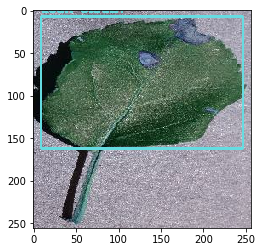

Cropped Image


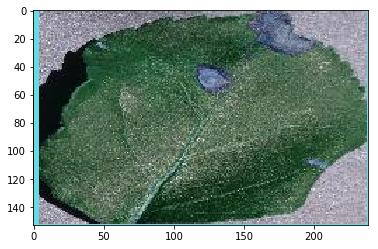

In [0]:
from matplotlib import pyplot as plt

# ensure at least one detection exists
if len(idxs) > 0:
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
        
        # draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)

# show the output cropped image
fin_x = x
fin_y = y
fin_xw = y+h
fin_yh = x+w
crop_img = image[fin_x:fin_xw,fin_y:fin_yh]

print("Image with Bounding Box")
plt.imshow(image)
plt.show()

print("Cropped Image")
plt.imshow(crop_img)
plt.show()



##Leaf Classifier

<!-- Since we recieved the cropped-image we can pass it over the main classifier to classifiy the input into the 8 classes of plants from the dataset.  -->

####Classifies the leaf among the following classes:
  * Apple
  * Cherry
  * Grape
  * Peach
  * Pepper
  * Potato
  * Strawberry
  * Tomato

####Load classifier weights

In [0]:
model = load_model('/content/drive/My Drive/Weights/LeafClassifier.h5')

####Image Rotation and Prediction

- Image is rotated in steps of 15° over 360 °
- Image is classified at every step
- The majority of the predictions is declared the output

In [0]:
predictions=[]
for i in range(8):
	predictions.append(0)
i=1
for angle in range(0,360,15):
    rotated = imutils.rotate_bound(crop_img,angle)
    cv2.imwrite("rotations/rotated_"+str(i)+".jpg",rotated)
    kerasimg = kimage.load_img('rotations/rotated_'+str(i)+".jpg",target_size=(224,224))
    kerasimg = kimage.img_to_array(kerasimg)
    kerasimg = np.expand_dims(kerasimg,axis=0)
    predvec = model.predict(kerasimg)[0].tolist()
    predindex = predvec.index(max(predvec))
    predictions[predindex] += 1
    i=i+1
print("The Frequency Distribution of Predictions:\n")
print(predictions)


The Frequency Distribution of Predictions:

[24, 0, 0, 0, 0, 0, 0, 0]


#### Convert List to Label

In [0]:
import shutil
category = {0:'Apple',
            1:'Cherry',
            2:'Grape',
            3:'Peach',
            4:'Pepper',
            5:'Potato',
            6:'Strawberry',
            7:'Tomato'}
print("The Image has "+category[predictions.index(max(predictions))]+" Leaf")
index = predictions.index(max(predictions))

The Image has Apple Leaf


##Disease Classifiers

####Initialize Weight Paths and Label

In [0]:
paths = {
0:'/content/drive/My Drive/Weights/appleweights.h5',
1:'/content/drive/My Drive/Weights/cherryweights.h5',
2:'/content/drive/My Drive/Weights/grapeweights.h5',
3:'/content/drive/My Drive/Weights/peachweights.h5',
4:'/content/drive/My Drive/Weights/pepperweights.h5',
5:'/content/drive/My Drive/Weights/potatoweights.h5',
6:'/content/drive/My Drive/Weights/strawberryweights.h5',
7:'/content/drive/My Drive/Weights/tomatoweights.h5'}

diseaselist = [['Apple Scab','Black Rot', 'Cedar Apple Rust','Healthy'],
['Healthy','Powdery Mildew'],
['Black Measles','Black Rot','Healthy','Isariopsis Leaf Spot'],
['Bacterial Spot','Healthy'],
['Bacterial Spot','Healthy'],
['Early Blight','Healthy','Late Blight'],
['Healthy','Leaf Scorch'],
['Bacterial Spot','Curl Virus','Early Blight','Healthy','Late Blight','Leaf Mold','Mosaic Virus','Septoria Leaf Spot','Spider Mites','Target Spot']]


####Load the Weights

In [0]:
def load_cherry():
	model = Sequential()
	model.add(ResNet50(include_top = False, pooling = 'avg'))
	model.add(Dense(2, activation = 'softmax'))
	model.layers[0].trainable = False
	model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
	model.summary()
	model.load_weights(paths[1])

In [0]:
def load_pepper():
	model = ResNet50(include_top=False,pooling='avg',weights="imagenet")
	x = model.output
	# x = Dense(1024,activation='relu')(x)
	x = Dropout(0.12)(x)
	predict = Dense(2,activation='softmax')(x)
	model = Model(input = model.input, output = predict)
	model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
	model.summary()
	model.load_weights(paths[4])


In [0]:
def load_strawberry():
	model = Sequential()
	model.add(ResNet50(include_top = False, pooling = 'avg'))
	model.add(Dense(2, activation = 'softmax'))
	model.layers[0].trainable = False
	model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
	model.summary()
	model.load_weights(paths[6])


In [0]:
def load_tomato():
	model = ResNet50(include_top=False,pooling='avg',weights="imagenet")
	x = model.output
	x = Dropout(0.12)(x)
	predict = Dense(10,activation='softmax')(x)
	model = Model(input = model.input, output = predict)  
	model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
	model.load_weights(paths[7])


In [0]:
if index in [0,2,3,5]:
	model = load_model(paths[index])
else:
	if index == 1:
		load_cherry()
	elif index == 4:
		load_pepper()
	elif index == 6:
		load_strawberry()
	else:
		load_tomato()   

####Process Image and Run Inference

In [0]:
kerasimg = kimage.load_img('/content/rotations/rotated_1.jpg',target_size=(224,224))
kerasimg = kimage.img_to_array(kerasimg)
kerasimg = np.expand_dims(kerasimg,axis=0)

    
temp = model.predict(kerasimg)
temp = temp[0].tolist()
disease = diseaselist[index][temp.index(max(temp))]
if disease=="Healthy":
    print("No Problem!")
else:q
    print("The leaf is infected. It has "+disease)

The leaf is infected. It has Black Rot
